# 1. Import Library

In [1]:
import pandas as pd
import numpy as np

import cv2
import os
from nltk import wordpunct_tokenize
import re

import itertools
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# You need extract file ml1m.zip to folder ml1m before run code

users = pd.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

In [3]:
movies_train

,title,genre
movieid,,
1650,Washington Square (1997),[Drama]
185,"Net, The (1995)","[Sci-Fi, Thriller]"
1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]"
3204,"Boys from Brazil, The (1978)",[Thriller]
1901,Dear Jesse (1997),[Documentary]
...,...,...
2539,Analyze This (1999),[Comedy]
3038,"Face in the Crowd, A (1957)",[Drama]
1832,Heaven's Burning (1997),"[Action, Drama]"


# 2.    Dataset + Load Image

## Train & Validation data

In [4]:
folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_train['id'] = movies_train.index
movies_train.reset_index(inplace=True)
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)

# Thay thế dấu gạch chéo ngược (\) thành dấu gạch chéo thuận (/) trong cột 'img_path'
movies_train['img_path'] = movies_train['img_path'].str.replace('\\', '/')

movies_train

C:\Users\nonam\AppData\Local\Temp\ipykernel_15428\2758354662.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies_train['img_path'] = movies_train['img_path'].str.replace('\\', '/')


,movieid,title,genre,id,img_path
0,1650,Washington Square (1997),[Drama],1650,ml1m/content/dataset/ml1m-images/1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185,ml1m/content/dataset/ml1m-images/185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377,ml1m/content/dataset/ml1m-images/1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204,ml1m/content/dataset/ml1m-images/3204.jpg
4,1901,Dear Jesse (1997),[Documentary],1901,ml1m/content/dataset/ml1m-images/1901.jpg
...,...,...,...,...,...
3101,2539,Analyze This (1999),[Comedy],2539,ml1m/content/dataset/ml1m-images/2539.jpg
3102,3038,"Face in the Crowd, A (1957)",[Drama],3038,ml1m/content/dataset/ml1m-images/3038.jpg
3103,1832,Heaven's Burning (1997),"[Action, Drama]",1832,ml1m/content/dataset/ml1m-images/1832.jpg
3104,657,Yankee Zulu (1994),"[Comedy, Drama]",657,ml1m/content/dataset/ml1m-images/657.jpg


In [5]:
print(movies_train.isnull().values.any())

False


In [6]:
# Breaks "Genre" into the constituting individual genres
def find_genres(genre):
    
    start = 0
    set_of_genre = []
    for i in range(len(genre)):
        
        k=0
        substring = ""
        if (genre[i]=='|'):
            substring = genre[start:i]
            start = i+1
            k = 1
        
        if(i==len(genre)-1):
            substring = genre[start:i+1]
            k = 1
            
        if (k==1):
            set_of_genre.append(substring)         
    
    return (set_of_genre)

In [7]:
# Extract list of genre values for each image
all_genre = []
Genre_list = movies_train['genre']

for i in range (len(Genre_list)):
    
    set_of_genre = find_genres(Genre_list[i])
    
    for j in range (len(set_of_genre)):
        all_genre.append(set_of_genre[j])
        
# uniq, counts = np.unique(all_genre, return_counts=True)
# print("Number of unique genres:", len(uniq))
# print("Unique genres are:", uniq)
# dict(zip(uniq, counts))
        
print(all_genre)

import itertools
from collections import Counter
# Kết hợp tất cả các danh sách thể loại thành một danh sách duy nhất
flattened_genre = list(itertools.chain.from_iterable(all_genre))

# Sử dụng Counter để đếm số lần xuất hiện của từng thể loại
genre_counts = Counter(flattened_genre)

# Hiển thị số lượng của từng thể loại
print("Số lượng tương ứng với từng thể loại:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

[['Drama'], ['Sci-Fi', 'Thriller'], ['Action', 'Adventure', 'Comedy', 'Crime'], ['Thriller'], ['Documentary'], ['Drama'], ['Action', 'Thriller'], ['Comedy'], ['Drama'], ['Drama'], ['Comedy', 'Drama'], ['Drama'], ['Comedy'], ['Drama'], ['Action', 'Adventure'], ['Action', 'Thriller'], ['Documentary'], ['Drama'], ['Drama'], ['Animation', "Children's"], ['Drama', 'Romance'], ['Drama', 'Thriller'], ['Action', 'Comedy'], ['Comedy'], ['Horror', 'Thriller'], ['Comedy', 'Romance'], ['Drama'], ['Drama'], ['Adventure', "Children's"], ['Comedy', 'Drama'], ['Comedy', 'Drama', 'Thriller'], ["Children's", 'Comedy'], ['Adventure', 'Drama'], ['Action', 'Thriller', 'War'], ['Comedy'], ['Animation', "Children's", 'Comedy', 'Musical'], ['Comedy', 'Drama', 'Romance'], ['Comedy'], ['Action', 'Sci-Fi', 'Thriller'], ['Action', 'Adventure', 'Sci-Fi'], ['Film-Noir'], ['Documentary'], ['Comedy'], ['Comedy'], ['Drama'], ['Action', 'Sci-Fi'], ['Animation', "Children's", 'Comedy', 'Musical', 'Romance'], ['Comedy', 

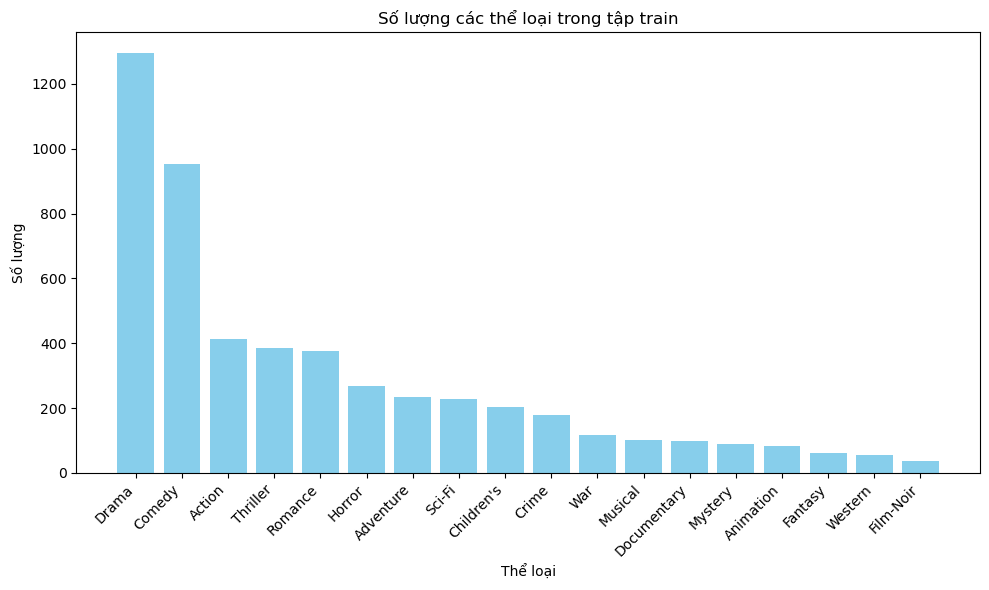

In [8]:
# Chuyển dữ liệu thành list để sắp xếp theo thứ tự giảm dần
sorted_genre_counts = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

# Tách thể loại và số lượng thành các list riêng biệt để vẽ biểu đồ
genres, counts = zip(*sorted_genre_counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue')
plt.xlabel('Thể loại')
plt.ylabel('Số lượng')
plt.title('Số lượng các thể loại trong tập train')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [9]:
# Prepare multi-hot-encoded-labels for the various genres
def multi_hot_encoded_labels(img_path, genre):
    
    col_names =  ['Action',
                  'Adventure',
                  'Animation',
                  'Children\'s',
                  'Comedy',
                  'Crime',
                  'Documentary',
                  'Drama',
                  'Fantasy',
                  'Film-Noir',
                  'Horror',
                  'Musical',
                  'Mystery',
                  'Romance',
                  'Sci-Fi',
                  'Thriller',    
                  'War',
                  'Western']
    
    set_of_genre = find_genres(genre)
    
    row=[]
    row.append(img_path)
    
    for col_name in col_names:
        if col_name in set_of_genre[0]:
            row.append(1)
        else:
            row.append(0)
    
    row.append(genre) #add the overall combined genre for record purposes
        
    return row  

In [10]:
movies_train

,movieid,title,genre,id,img_path
0,1650,Washington Square (1997),[Drama],1650,ml1m/content/dataset/ml1m-images/1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185,ml1m/content/dataset/ml1m-images/185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377,ml1m/content/dataset/ml1m-images/1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204,ml1m/content/dataset/ml1m-images/3204.jpg
4,1901,Dear Jesse (1997),[Documentary],1901,ml1m/content/dataset/ml1m-images/1901.jpg
...,...,...,...,...,...
3101,2539,Analyze This (1999),[Comedy],2539,ml1m/content/dataset/ml1m-images/2539.jpg
3102,3038,"Face in the Crowd, A (1957)",[Drama],3038,ml1m/content/dataset/ml1m-images/3038.jpg
3103,1832,Heaven's Burning (1997),"[Action, Drama]",1832,ml1m/content/dataset/ml1m-images/1832.jpg
3104,657,Yankee Zulu (1994),"[Comedy, Drama]",657,ml1m/content/dataset/ml1m-images/657.jpg


In [11]:
set_of_genre = find_genres(movies_train['genre'][2])
print(set_of_genre)

[['Action', 'Adventure', 'Comedy', 'Crime']]


In [12]:
print(set_of_genre[0][1])

Adventure


In [13]:
print(multi_hot_encoded_labels('ml1m/content/dataset/ml1m-images/1377.jpg',['Action', 'Adventure', 'Comedy', 'Crime']))

['ml1m/content/dataset/ml1m-images/1377.jpg', 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ['Action', 'Adventure', 'Comedy', 'Crime']]


In [31]:
# Perform the encoding of the labels and save data in the format :
# Img-ID <multi-hot-encoded-labels> overall_genre
all_data = []

for index, row in tqdm(movies_train.iterrows()):
    
    path = row['img_path']
    genre = row['genre']
    row = multi_hot_encoded_labels(path, genre)
    
    all_data.append(row)

    col_names =  ['Action',
                  'Adventure',
                  'Animation',
                  'Children\'s',
                  'Comedy',
                  'Crime',
                  'Documentary',
                  'Drama',
                  'Fantasy',
                  'Film-Noir',
                  'Horror',
                  'Musical',
                  'Mystery',
                  'Romance',
                  'Sci-Fi',
                  'Thriller',    
                  'War',
                  'Western']

all_data = pd.DataFrame(all_data)

3106it [00:00, 27863.29it/s]


In [32]:
all_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ml1m/content/dataset/ml1m-images/1650.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
1,ml1m/content/dataset/ml1m-images/185.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,"[Sci-Fi, Thriller]"
2,ml1m/content/dataset/ml1m-images/1377.jpg,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"[Action, Adventure, Comedy, Crime]"
3,ml1m/content/dataset/ml1m-images/3204.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,[Thriller]
4,ml1m/content/dataset/ml1m-images/1901.jpg,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,[Documentary]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,ml1m/content/dataset/ml1m-images/2539.jpg,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,[Comedy]
3102,ml1m/content/dataset/ml1m-images/3038.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
3103,ml1m/content/dataset/ml1m-images/1832.jpg,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Action, Drama]"
3104,ml1m/content/dataset/ml1m-images/657.jpg,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Comedy, Drama]"


In [33]:
df_encoded = all_data

df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ml1m/content/dataset/ml1m-images/1650.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
1,ml1m/content/dataset/ml1m-images/185.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,"[Sci-Fi, Thriller]"
2,ml1m/content/dataset/ml1m-images/1377.jpg,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"[Action, Adventure, Comedy, Crime]"
3,ml1m/content/dataset/ml1m-images/3204.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,[Thriller]
4,ml1m/content/dataset/ml1m-images/1901.jpg,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,[Documentary]


In [34]:
col_names_full =  ['Img_paths',
              'Action',
                  'Adventure',
                  'Animation',
                  'Children\'s',
                  'Comedy',
                  'Crime',
                  'Documentary',
                  'Drama',
                  'Fantasy',
                  'Film-Noir',
                  'Horror',
                  'Musical',
                  'Mystery',
                  'Romance',
                  'Sci-Fi',
                  'Thriller',    
                  'War',
                  'Western',
                  'Genre']
df_encoded.columns = col_names_full
df_encoded

,Img_paths,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Genre
0,ml1m/content/dataset/ml1m-images/1650.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
1,ml1m/content/dataset/ml1m-images/185.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,"[Sci-Fi, Thriller]"
2,ml1m/content/dataset/ml1m-images/1377.jpg,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"[Action, Adventure, Comedy, Crime]"
3,ml1m/content/dataset/ml1m-images/3204.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,[Thriller]
4,ml1m/content/dataset/ml1m-images/1901.jpg,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,[Documentary]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,ml1m/content/dataset/ml1m-images/2539.jpg,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,[Comedy]
3102,ml1m/content/dataset/ml1m-images/3038.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
3103,ml1m/content/dataset/ml1m-images/1832.jpg,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Action, Drama]"
3104,ml1m/content/dataset/ml1m-images/657.jpg,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Comedy, Drama]"


In [35]:
print(df_encoded.columns)

Index(['Img_paths', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'Genre'],
      dtype='object')


In [36]:
def find_nonexistent_images(df):
    non_existing_images = []
    for index, row in df.iterrows():
        img_path = row['Img_paths']
        if not os.path.exists(img_path):
            non_existing_images.append(img_path)
    
    return non_existing_images

# Tìm ảnh không tồn tại trong tập train_df
non_existing_train_images = find_nonexistent_images(df_encoded)

# Hiển thị danh sách các ảnh không tồn tại
notFound = 0
for img_path in non_existing_train_images:
    print(f"Image not found: {img_path}")
    notFound += 1

print("\nTổng số ảnh không tìm thấy trong file là: ",notFound)

Image not found: ml1m/content/dataset/ml1m-images/1901.jpg
Image not found: ml1m/content/dataset/ml1m-images/758.jpg
Image not found: ml1m/content/dataset/ml1m-images/1636.jpg
Image not found: ml1m/content/dataset/ml1m-images/3126.jpg
Image not found: ml1m/content/dataset/ml1m-images/794.jpg
Image not found: ml1m/content/dataset/ml1m-images/2304.jpg
Image not found: ml1m/content/dataset/ml1m-images/3522.jpg
Image not found: ml1m/content/dataset/ml1m-images/3202.jpg
Image not found: ml1m/content/dataset/ml1m-images/2933.jpg
Image not found: ml1m/content/dataset/ml1m-images/1146.jpg
Image not found: ml1m/content/dataset/ml1m-images/1795.jpg
Image not found: ml1m/content/dataset/ml1m-images/895.jpg
Image not found: ml1m/content/dataset/ml1m-images/1830.jpg
Image not found: ml1m/content/dataset/ml1m-images/2564.jpg
Image not found: ml1m/content/dataset/ml1m-images/1710.jpg
Image not found: ml1m/content/dataset/ml1m-images/3636.jpg
Image not found: ml1m/content/dataset/ml1m-images/3609.jpg


In [37]:
df_encoded = df_encoded[~df_encoded['Img_paths'].isin(non_existing_train_images)]

In [38]:
# Tìm ảnh không tồn tại trong tập train_df
check_again_non_existing_train_images = find_nonexistent_images(df_encoded)

# Hiển thị danh sách các ảnh không tồn tại
notFound = 0
for img_path in check_again_non_existing_train_images:
    print(f"Image not found: {img_path}")
    notFound += 1

print("\nTổng số ảnh không tìm thấy trong file là: ",notFound)


Tổng số ảnh không tìm thấy trong file là:  0


In [39]:
# To split into train / validation / test in the ratio 85% / 15%
random_seed = 50
train_df = df_encoded.sample(frac=0.9, random_state=random_seed) #Taking 70% of the data
valid_df = df_encoded.drop(train_df.index)

print("Train_df=",len(train_df))
print("Val_df=",len(valid_df))

np.savetxt("Train.csv", train_df, fmt='%s', delimiter=",")
np.savetxt("Valid.csv", valid_df, fmt='%s', delimiter=",")

#Numpy method
#train, validate, test = np.split(df_encoded.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
#np.split will split at 60% of the length of the shuffled array, 
#then 80% of length (which is an additional 20% of data), thus leaving a remaining 20% of the data.

Train_df= 2342
Val_df= 260


## Test data

In [23]:
movies_test

,title,genre
movieid,,
3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]"
2067,Doctor Zhivago (1965),"[Drama, Romance, War]"
2651,Frankenstein Meets the Wolf Man (1943),[Horror]
2989,For Your Eyes Only (1981),[Action]
3415,"Mirror, The (Zerkalo) (1975)",[Drama]
...,...,...
2309,"Inheritors, The (Die Siebtelbauern) (1998)",[Drama]
2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]"
3255,"League of Their Own, A (1992)","[Comedy, Drama]"


In [24]:
folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_test['id'] = movies_test.index
movies_test.reset_index(inplace=True)
movies_test['img_path'] = movies_test.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)
movies_test['img_path'] = movies_test['img_path'].str.replace('\\', '/')
movies_test

C:\Users\nonam\AppData\Local\Temp\ipykernel_15428\3037691778.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies_test['img_path'] = movies_test['img_path'].str.replace('\\', '/')


,movieid,title,genre,id,img_path
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397,ml1m/content/dataset/ml1m-images/3397.jpg
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067,ml1m/content/dataset/ml1m-images/2067.jpg
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651,ml1m/content/dataset/ml1m-images/2651.jpg
3,2989,For Your Eyes Only (1981),[Action],2989,ml1m/content/dataset/ml1m-images/2989.jpg
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415,ml1m/content/dataset/ml1m-images/3415.jpg
...,...,...,...,...,...
772,2309,"Inheritors, The (Die Siebtelbauern) (1998)",[Drama],2309,ml1m/content/dataset/ml1m-images/2309.jpg
773,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",2421,ml1m/content/dataset/ml1m-images/2421.jpg
774,3255,"League of Their Own, A (1992)","[Comedy, Drama]",3255,ml1m/content/dataset/ml1m-images/3255.jpg
775,974,Algiers (1938),"[Drama, Romance]",974,ml1m/content/dataset/ml1m-images/974.jpg


In [25]:
# Perform the encoding of the labels and save data in the format :
# Img-ID <multi-hot-encoded-labels> overall_genre
Test_df = []

for index, row in tqdm(movies_test.iterrows()):
    
    path = row['img_path']
    genre = row['genre']
    row = multi_hot_encoded_labels(path, genre)
    
    Test_df.append(row)

    col_names =  ['Action',
                  'Adventure',
                  'Animation',
                  'Children\'s',
                  'Comedy',
                  'Crime',
                  'Documentary',
                  'Drama',
                  'Fantasy',
                  'Film-Noir',
                  'Horror',
                  'Musical',
                  'Mystery',
                  'Romance',
                  'Sci-Fi',
                  'Thriller',    
                  'War',
                  'Western']

Test_df = pd.DataFrame(Test_df)

# Save DataFrame to CSV
Test_df.to_csv("Test.csv", index=False, header=False) 

777it [00:00, 23337.56it/s]


In [26]:
Test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ml1m/content/dataset/ml1m-images/3397.jpg,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Children's, Comedy]"
1,ml1m/content/dataset/ml1m-images/2067.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,"[Drama, Romance, War]"
2,ml1m/content/dataset/ml1m-images/2651.jpg,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,[Horror]
3,ml1m/content/dataset/ml1m-images/2989.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[Action]
4,ml1m/content/dataset/ml1m-images/3415.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,ml1m/content/dataset/ml1m-images/2309.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
773,ml1m/content/dataset/ml1m-images/2421.jpg,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Action, Adventure, Drama]"
774,ml1m/content/dataset/ml1m-images/3255.jpg,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Comedy, Drama]"
775,ml1m/content/dataset/ml1m-images/974.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,"[Drama, Romance]"


In [27]:
Test_df.columns = col_names_full
Test_df

,Img_paths,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Genre
0,ml1m/content/dataset/ml1m-images/3397.jpg,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Children's, Comedy]"
1,ml1m/content/dataset/ml1m-images/2067.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,"[Drama, Romance, War]"
2,ml1m/content/dataset/ml1m-images/2651.jpg,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,[Horror]
3,ml1m/content/dataset/ml1m-images/2989.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[Action]
4,ml1m/content/dataset/ml1m-images/3415.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,ml1m/content/dataset/ml1m-images/2309.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
773,ml1m/content/dataset/ml1m-images/2421.jpg,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Action, Adventure, Drama]"
774,ml1m/content/dataset/ml1m-images/3255.jpg,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Comedy, Drama]"
775,ml1m/content/dataset/ml1m-images/974.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,"[Drama, Romance]"


In [41]:
# Tìm ảnh không tồn tại trong tập train_df
non_existing_test_images = find_nonexistent_images(Test_df)

# Hiển thị danh sách các ảnh không tồn tại
notFound = 0
for img_path in non_existing_test_images:
    print(f"Image not found: {img_path}")
    notFound += 1

print("\nTổng số ảnh không tìm thấy trong file test là: ",notFound)

Image not found: ml1m/content/dataset/ml1m-images/576.jpg
Image not found: ml1m/content/dataset/ml1m-images/1118.jpg
Image not found: ml1m/content/dataset/ml1m-images/559.jpg
Image not found: ml1m/content/dataset/ml1m-images/1557.jpg
Image not found: ml1m/content/dataset/ml1m-images/1577.jpg
Image not found: ml1m/content/dataset/ml1m-images/878.jpg
Image not found: ml1m/content/dataset/ml1m-images/634.jpg
Image not found: ml1m/content/dataset/ml1m-images/2030.jpg
Image not found: ml1m/content/dataset/ml1m-images/821.jpg
Image not found: ml1m/content/dataset/ml1m-images/1159.jpg
Image not found: ml1m/content/dataset/ml1m-images/3237.jpg
Image not found: ml1m/content/dataset/ml1m-images/2955.jpg
Image not found: ml1m/content/dataset/ml1m-images/1164.jpg
Image not found: ml1m/content/dataset/ml1m-images/1538.jpg
Image not found: ml1m/content/dataset/ml1m-images/2934.jpg
Image not found: ml1m/content/dataset/ml1m-images/2063.jpg
Image not found: ml1m/content/dataset/ml1m-images/3288.jpg
Im

In [42]:
Test_df = Test_df[~Test_df['Img_paths'].isin(non_existing_test_images)]

In [44]:
Test_df

,Img_paths,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Genre
0,ml1m/content/dataset/ml1m-images/3397.jpg,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Children's, Comedy]"
1,ml1m/content/dataset/ml1m-images/2067.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,"[Drama, Romance, War]"
2,ml1m/content/dataset/ml1m-images/2651.jpg,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,[Horror]
3,ml1m/content/dataset/ml1m-images/2989.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[Action]
4,ml1m/content/dataset/ml1m-images/3415.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,[Drama]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,ml1m/content/dataset/ml1m-images/1286.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,"[Drama, Romance]"
773,ml1m/content/dataset/ml1m-images/2421.jpg,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Action, Adventure, Drama]"
774,ml1m/content/dataset/ml1m-images/3255.jpg,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Comedy, Drama]"
775,ml1m/content/dataset/ml1m-images/974.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,"[Drama, Romance]"


# 3.    Model & Train

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import cv2
from keras import models
from keras import layers
from keras import optimizers


In [46]:
def arrange_data(df):           # df chua thong tin hinh anh va nhan
    
    image_data = []             # Tao danh sach rong de luu hinh anh sau khi duoc chuan bi
    img_paths = np.asarray(df.iloc[:, 0])   # Lay duong dan tu cot dau tien va chuyen doi thanh mang numpy
    
    for i in tqdm(range(len(img_paths))):
              
        img = image.load_img(img_paths[i],target_size=(200,150,3))  #Tải hình ảnh từ đường dẫn và thay đổi kích thước của hình ảnh thành (200, 150, 3) sử dụng thư viện keras.preprocessing.image.
        img = image.img_to_array(img)   #Chuyển đổi hình ảnh thành mảng NumPy
        img = img/255   # Chuẩn hóa giá trị pĩel từ o -1
        image_data.append(img)
    
    X = np.array(image_data)       # Chuyển danh sách hình ảnh thành 1 mảng numpy
    Y = np.array(df.iloc[:,1:19])   # Lẫy nhãn từ cột 1 đến 19 (tình từ cột thued 2) → chuyẻn đổi thành mảng numoy
    
    print("Shape of images:", X.shape)
    print("Shape of labels:", Y.shape)
    
    return X, Y

In [47]:
print("Xử lý dữ liệu tập Train..")
X_train, Y_train = arrange_data (train_df)

print("Xử lý dữ liệu tập Valid..")
X_val, Y_val = arrange_data (valid_df)

Xử lý dữ liệu tập Train..


100%|██████████| 2342/2342 [00:20<00:00, 115.49it/s]


Shape of images: (2342, 200, 150, 3)
Shape of labels: (2342, 18)
Xử lý dữ liệu tập Valid..


100%|██████████| 260/260 [00:02<00:00, 96.94it/s] 

Shape of images: (260, 200, 150, 3)
Shape of labels: (260, 18)


## Model

In [48]:
num_classes = 18

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(200,150,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 146, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 73, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 98, 73, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 69, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 47, 34, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 47, 34, 32)        0

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val), batch_size=64)
model.save('Model_6c.h5')

Epoch 1/30
37/37 [==============================] - 47s 1s/step - loss: 0.4787 - accuracy: 0.0901 - val_loss: 0.4233 - val_accuracy: 0.2769
Epoch 2/30
37/37 [==============================] - 44s 1s/step - loss: 0.3511 - accuracy: 0.1584 - val_loss: 0.3427 - val_accuracy: 0.2846
Epoch 3/30
37/37 [==============================] - 57s 2s/step - loss: 0.3224 - accuracy: 0.2092 - val_loss: 0.3177 - val_accuracy: 0.2846
Epoch 4/30
37/37 [==============================] - 52s 1s/step - loss: 0.3130 - accuracy: 0.2216 - val_loss: 0.3056 - val_accuracy: 0.2846
Epoch 5/30
37/37 [==============================] - 47s 1s/step - loss: 0.3040 - accuracy: 0.2387 - val_loss: 0.2859 - val_accuracy: 0.2846
Epoch 6/30
37/37 [==============================] - 46s 1s/step - loss: 0.2955 - accuracy: 0.2635 - val_loss: 0.2839 - val_accuracy: 0.2846
Epoch 7/30
37/37 [==============================] - 46s 1s/step - loss: 0.2939 - accuracy: 0.2558 - val_loss: 0.2862 - val_accuracy: 0.2846
Epoch 8/30
37/37 [==

c:\Users\nonam\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
print(history.history)

{'loss': [0.4787347912788391, 0.351146936416626, 0.3223581314086914, 0.3129902184009552, 0.304045706987381, 0.2955106198787689, 0.29388612508773804, 0.2917477488517761, 0.2882874608039856, 0.2838042378425598, 0.2830507159233093, 0.28062644600868225, 0.27945640683174133, 0.27760547399520874, 0.2770729959011078, 0.27593907713890076, 0.2729445695877075, 0.2723366916179657, 0.27271825075149536, 0.27199387550354004, 0.26912593841552734, 0.26810160279273987, 0.26749110221862793, 0.2659326493740082, 0.26331502199172974, 0.26161321997642517, 0.26087453961372375, 0.2605820894241333, 0.2589738070964813, 0.2583993673324585], 'accuracy': [0.0900939404964447, 0.15841160714626312, 0.20922288298606873, 0.22160546481609344, 0.23868487775325775, 0.2634500563144684, 0.25576430559158325, 0.26771989464759827, 0.27754056453704834, 0.28266438841819763, 0.2847993075847626, 0.28864219784736633, 0.27796754240989685, 0.2873612344264984, 0.2805294692516327, 0.3040136694908142, 0.2920580804347992, 0.2890691757202

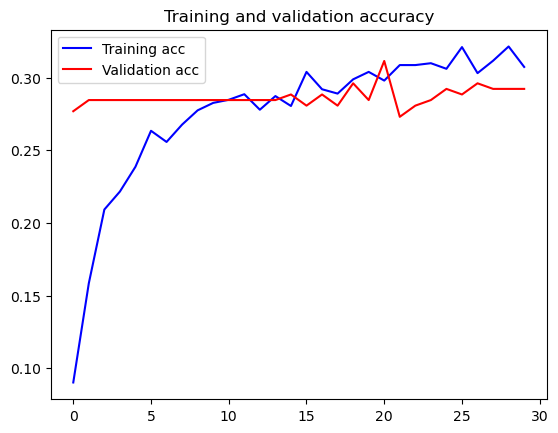

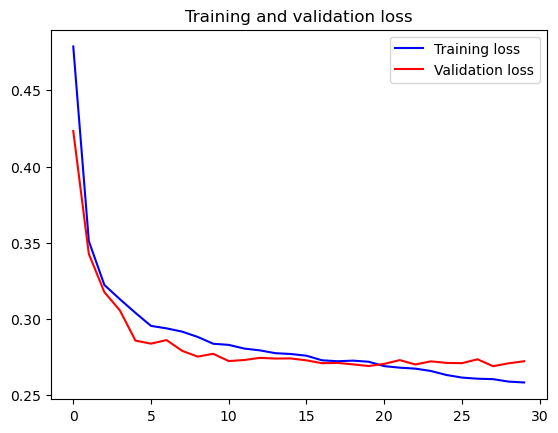

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test accuracy, single_image

## Accuracy

In [51]:
X_test, Y_test = arrange_data (Test_df)

pred = model.predict(np.array(X_test))

count = 0
for i in tqdm(range(len(pred))):
    value = 0
        
    first3_index = np.argsort(pred[i])[-3:]
    correct = np.where(Y_test[i] == 1)[0]
        
    for j in first3_index:
        if j in correct:
            value += 1
                
    if (value>0):
        count=count+1
                
print("Hình ảnh có ít nhất một thể loại được xác định chính xác = ",count)
print("Tổng số hình ảnh = ",len(pred))
print("Accuracy = ", count/len(pred))

100%|██████████| 654/654 [00:06<00:00, 107.47it/s]


Shape of images: (654, 200, 150, 3)
Shape of labels: (654, 18)
21/21 [==============================] - 2s 93ms/step


100%|██████████| 654/654 [00:00<00:00, 42155.10it/s]

Hình ảnh có ít nhất một thể loại được xác định chính xác =  482
Tổng số hình ảnh =  654
Accuracy =  0.7370030581039755


## Image

In [70]:
np.savetxt("Encoded_data_column_lookup.csv", np.asarray(col_names), fmt='%s', delimiter=" ")

In [67]:
def find_genre(test_path, model):
    img = image.load_img(test_path,target_size=(200,150,3))
    img = image.img_to_array(img)
    img = img/255
    prob = model.predict(img.reshape(1,200,150,3))

    top_3 = np.argsort(prob[0])[:-4:-1]

    column_lookups = pd.read_csv("Encoded_data_column_lookup.csv", delimiter=" ")
    classes = np.asarray(column_lookups.iloc[1:19, 0])

    for i in range(3):
        print("{}".format(classes[top_3[i]])+" ({:.3})".format(prob[0][top_3[i]]))
    plt.imshow(img)

In [62]:
from keras.models import load_model

def find_genre(test_path, model_path):
    model = load_model(model_path)  # Load the model without specifying the encoding
    img = image.load_img(test_path, target_size=(200, 150, 3))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    genre = model.predict(img)
    # Further processing with predicted genre...
    return genre


1/1 [==============================] - 0s 22ms/step


Documentary (0.433)
Film-Noir (0.375)
Thriller (0.18)


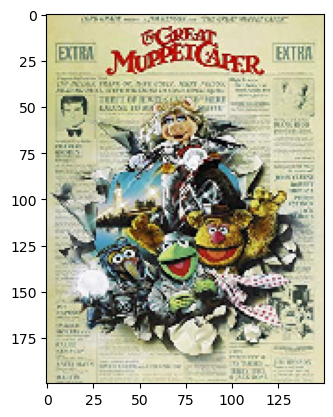

In [71]:
find_genre('ml1m/content/dataset/ml1m-images/3397.jpg',model)

1/1 [==============================] - 0s 22ms/step
Documentary (0.435)
Film-Noir (0.409)
Thriller (0.181)


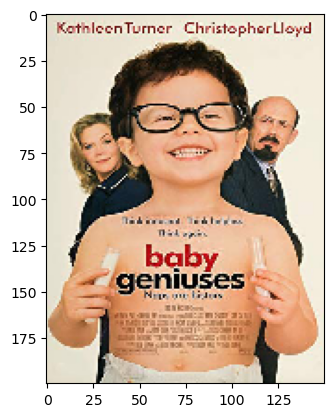

In [72]:
find_genre('ml1m/content/dataset/ml1m-images/2555.jpg',model)

1/1 [==============================] - 0s 20ms/step


Western (0.451)
Animation (0.356)
Film-Noir (0.342)


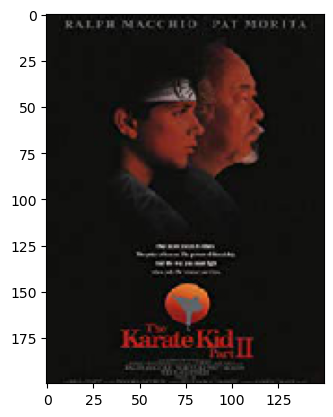

In [74]:
find_genre('ml1m/content/dataset/ml1m-images/2421.jpg',model)